# AIPI 590 - XAI | Assignment #04
### Explainable Techniques II
### Ayush Gupta



[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1qKbAlXapO-t4pL2oCZgWNQdOqg0jkWo6#scrollTo=4lZibPTBf216)

In [1]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# Load Diabetes dataset
diabetes = load_diabetes()
data = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
data['Target'] = diabetes.target  # Target variable

In [5]:
data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


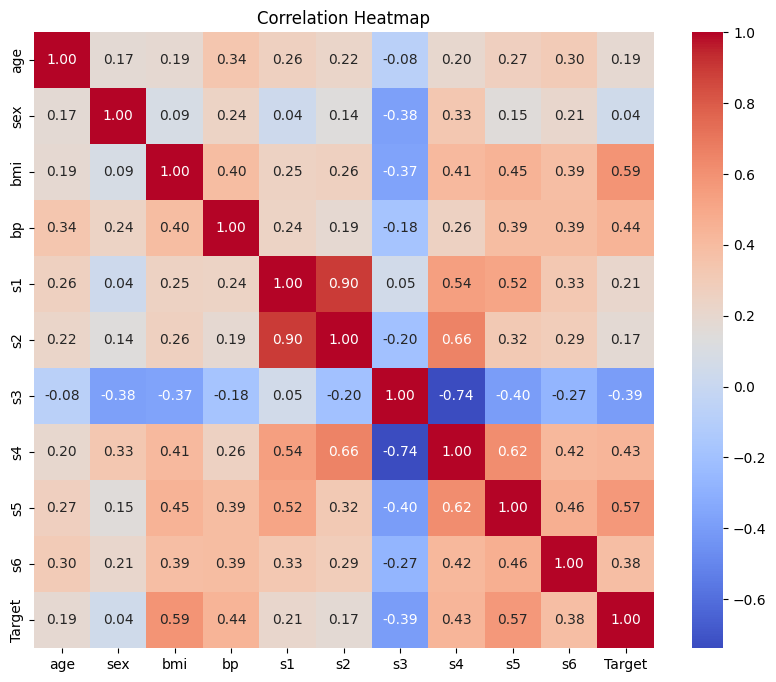

In [3]:
# Exploratory Data Analysis: Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

BMI and Target: BMI is moderately positively correlated with the target (correlation ~0.59), indicating that as BMI increases, the model predicts a higher diabetes progression.

BP and Target: Blood pressure (BP) shows a moderate positive correlation (~0.44) with the target.

S5 and Target: S5 (likely related to a blood serum measurement) has a relatively strong positive correlation (~0.57) with the target, making it another important feature.

Highly correlated features like S1 and S2 (correlation ~0.90) may affect interpretability when included together in the model.








In [4]:
# Split the data
X = data.drop("Target", axis=1)
y = data["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

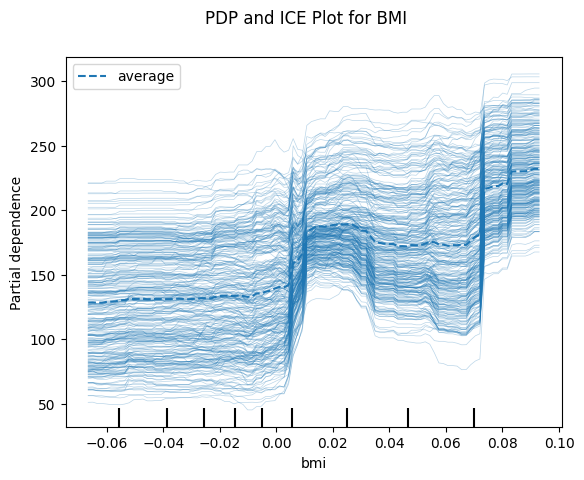

In [7]:
feature_to_plot = 'bmi'
PartialDependenceDisplay.from_estimator(model, X_train, [feature_to_plot], kind="both")
plt.suptitle("PDP and ICE Plot for BMI")
plt.show()


PDP plot shows how the average model prediction changes, when we vary BMI. PDP shows an overall upward trend as BMI increases, indicating that the model's prediction for diabetes progression increases on average.

Between the range of 0 to 0.02 and 0.06 to 0.08 shows a steep change. This means that a small changes within that range leads to large changes in the model's predictions. Beyong 0.08 BMI, we see saturaion in the prediction effects.

Model predicts a strong increase in diabetic progression when BMI changes within the range of 0.02 to 0.06.

The ICE curves shows how individual data points behaves when BMI changes. At low BMI values, ICE curves are flat depicting that BMI has little impact on predictions for people with low BMI.

Between 0.02 to 0.06 BMI, ICE curves increases steeply depicting that BMI in this range has a dramatic impact on model's predictions. The ICE curves shows a wide impact, for some people a little change in BMI shows a significant impact on model's predictions.

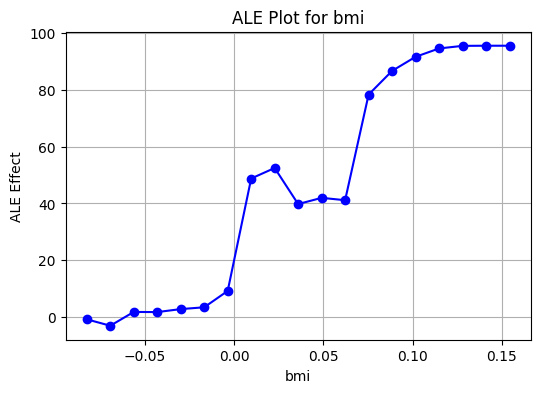

In [8]:
import numpy as np
# Manual ALE Calculation and Plot
# Divide the feature into bins
n_bins = 20
feature_values = np.linspace(X_train[feature_to_plot].min(), X_train[feature_to_plot].max(), n_bins)
bin_centers = (feature_values[:-1] + feature_values[1:]) / 2
ale_effects = []

for i in range(len(feature_values) - 1):
    # Get samples within the bin
    mask = (X_train[feature_to_plot] >= feature_values[i]) & (X_train[feature_to_plot] < feature_values[i + 1])
    X_temp = X_train[mask].copy()
    if len(X_temp) == 0:
        ale_effects.append(0)
        continue

    # Calculate predictions for bin edges
    X_temp[feature_to_plot] = feature_values[i]
    pred_low = model.predict(X_temp)
    X_temp[feature_to_plot] = feature_values[i + 1]
    pred_high = model.predict(X_temp)

    # Calculate ALE effect
    ale_effects.append(np.mean(pred_high - pred_low))

# Cumulative sum to get ALE plot
ale_cumulative = np.cumsum(ale_effects)

# Plotting the ALE plot
plt.figure(figsize=(6, 4))
plt.plot(bin_centers, ale_cumulative, marker='o', linestyle='-', color='b')
plt.xlabel(feature_to_plot)
plt.ylabel('ALE Effect')
plt.title(f'ALE Plot for {feature_to_plot}')
plt.grid(True)
plt.show()


The ALE curves shows a general upward trend, meaning that with inccreae in BMI the model predicts higher diabetic progression.

The steeper the slope the stronger the impact of BMI in that range. The ALE curve is constant until BMI = 0, showing little effect on model's predictions for low BMIs. ALE curves rise rapidly for BMI between 0 and 0.06, indicating that this is a critical range where increasing BMI leads to significant changes in predicted diabetes progression.

The curve flattens again, after BMI > 0.08 suggesting a saturation effect—further increases in BMI no longer have a significant impact on the model’s predictions.



#### Comparing PDP and ALE plots

The PDP showed a similar upward trend, but since it’s an average effect, it couldn’t pinpoint the exact local regions where BMI had the most impact.
The ALE plot highlights the critical range (0 to 0.06) much more clearly, emphasizing the importance of local analysis when features exhibit nonlinear effects.


#### Exploratory Findings on Correlation and Their Impact

BMI (correlation ~0.59 with Target): BMI shows a strong positive correlation with the target variable (diabetes progression), which is reflected in the PDP, ICE, and ALE plots. The significant increase in prediction as BMI rises indicates its critical role in the model's output. This feature's strong correlation ensures that it is a dominant predictor.

